# Hourly data resampling
We needed a mass-conserving time-averaging method to resample instantaneous streamflow observation into time-period averages. Here we plot a test case to show why this is needed.

Full tests in: `6_flow_data/99_resample_code_test_cases`

In [128]:
import numpy as np
import pandas as pd
from scipy import integrate
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [99]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [102]:
# Image output folder
image_folder = cs.read_from_config(config_file, 'image_path')

In [103]:
image_path = Path(image_folder)
image_path.mkdir(exist_ok=True, parents=True)

### Test case 0 - why do a volume preserving approach?
Instantaneous values are only valid at the point in time that they are taken. By estimating the progression of the hydrograph between IV measurements, integrating between these estimates to find the volume of water that passed during a given window, and dividing by the window size we get an estimate of the average flow rate over the window. 

The downside of this approach is that the actual measured values are lost.

In [119]:
time = [pd.to_datetime('2000-01-01 11:00'),
        pd.to_datetime('2000-01-01 11:30'), #N
        pd.to_datetime('2000-01-01 12:00'),
        pd.to_datetime('2000-01-01 12:30'), #N
        pd.to_datetime('2000-01-01 13:00'),
        pd.to_datetime('2000-01-01 13:15'), #N
        pd.to_datetime('2000-01-01 14:00'),
        pd.to_datetime('2000-01-01 14:30'), #N
        pd.to_datetime('2000-01-01 15:00')]
data = np.array([0,1,2,1.5,1,1.75,4,3,2]) #np.array([0,2,1,4,2])
df0  = pd.DataFrame({'time': time, 'data': data})
df0  = df0.set_index('time')

In [120]:
# Application of pd.resample.mean directly on instantaneous values
df0['resample_hourly_mean'] = df0.resample('1H').mean()

In [121]:
# pd.resamepl('1H').mean() returns only one value per resample period. E.g.
# Time,  data, resampled hourly mean
# 11:00, 0,    0.5
# 11:30, 1,    NaN
# 12:00, 2,    1.75
# 12:30, 1.5,  NaN
# etc.
# Here we fill the missing values to ease plotting later
df0['resample_hourly_mean'] = df0['resample_hourly_mean'].ffill()

In [122]:
# This is all needed to set up the use of integrate.trapezoid in the next block
df0['time_diff_in_sec'] = (df0.index - df0.index[0]).total_seconds()
x1 = df0['time_diff_in_sec'].values.reshape(-1,1)
y1 = df0['data'].values.reshape(-1,1)
y2 = df0['data'].shift(periods=-1).values.reshape(-1,1) 
x2 = df0['time_diff_in_sec'].shift(periods=-1).values.reshape(-1,1)
x = np.hstack([x1,x2])
y = np.hstack([y1,y2])

In [123]:
# Get the volumes per 30-minute time window
df0['volume_between_now_and_next'] = integrate.trapezoid(y,x=x)

In [124]:
# Convert the volume over the time window into an average rate for the time time window
time_spacing = (df0.index[1] - df0.index[0]).total_seconds()
df0['mean_per_timestep'] = df0['volume_between_now_and_next'] / time_spacing

In [125]:
# Now we have the average flow over the 30-minute time windows (instead of instantaneous observations
#  that are only valid at the moment of observations) we can in fact use resample('1H').mean() to get
#  the average flow over the 1h time window
df0['integrate_hourly_mean'] = df0['mean_per_timestep'].resample('1H').mean()
df0['integrate_hourly_mean'] = df0['integrate_hourly_mean'].ffill()

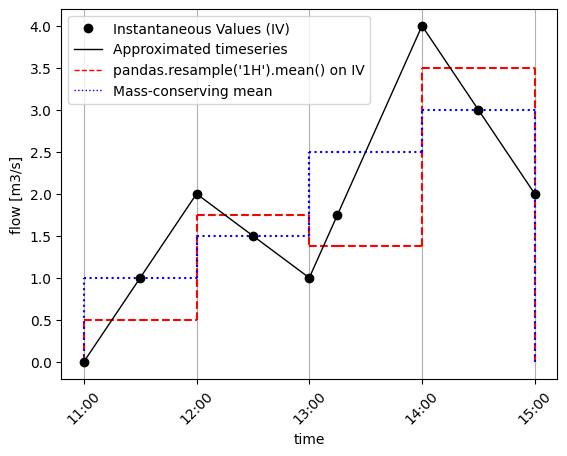

In [126]:
fig,ax = plt.subplots(1,1)

# vertical lines
for ix in range(len(df0)):
    if ix == 0: # left edge
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], 
                      [0, df0.iloc[ix].resample_hourly_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], 
                      [0, df0.iloc[ix].integrate_hourly_mean], fmt=':', color='b')
    elif ix == len(df0)-1: # right edge
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], 
                      [0, df0.iloc[ix-1].resample_hourly_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], 
                      [0, df0.iloc[ix-1].integrate_hourly_mean], fmt=':', color='b')
    else: # middle sections
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name],
                      [df0.iloc[ix-1].resample_hourly_mean, 
                       df0.iloc[ix].resample_hourly_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix+1].name, df0.iloc[ix+1].name],
                      [df0.iloc[ix].resample_hourly_mean, 
                       df0.iloc[ix].resample_hourly_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name],
                      [df0.iloc[ix-1].integrate_hourly_mean, 
                       df0.iloc[ix].integrate_hourly_mean], fmt=':', color='b')
        plt.plot_date([df0.iloc[ix+1].name, df0.iloc[ix+1].name],
                      [df0.iloc[ix].integrate_hourly_mean, 
                       df0.iloc[ix+1].integrate_hourly_mean], fmt=':', color='b')

# horizontal lines
for ix in range(len(df0)-1):
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].resample_hourly_mean, 
                   df0.iloc[ix].resample_hourly_mean], fmt='--', color='r')
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].integrate_hourly_mean, 
                   df0.iloc[ix].integrate_hourly_mean], fmt=':', color='b')
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].data, df0.iloc[ix+1].data], fmt='-', color='k', lw=1)

# Dots
ax.plot(df0['data'], marker='o', markeredgecolor='k',markerfacecolor='k',linestyle='')

# Chart junk
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(ax.get_xticks()[[0,2,4,6,8]])
ax.grid(axis='x');

plt.xticks(rotation=45);
plt.xlabel('time');
plt.ylabel('flow [m3/s]');

legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='k',markerfacecolor='k',linestyle='', 
                          label='Instantaneous Values (IV)'),
                   Line2D([0], [0], color='k', linestyle='-',  lw=1, label='Approximated timeseries'),
                   Line2D([0], [0], color='r', linestyle='--', lw=1, label='pandas.resample(\'1H\').mean() on IV'),
                   Line2D([0], [0], color='b', linestyle=':',  lw=1, label='Mass-conserving mean')
                   ]

plt.legend(handles=legend_elements);
plt.savefig(image_path / 'resampling_example.png', dpi=300, bbox_inches='tight')